# Fun with Astrometry

**LSST-DA Data Science Fellowship Program**

*by Alex Drlica-Wagner (2025-09-15)*

In this notebook we explore a few features related to astrometry and proper motion. I've attempted to follow the mathematical notation used in the lecture notes, though you may also want to look at Gary Bernstein's notes from DSFP Session 11.

*Acknowledgements: This notebook draws inspiration from previous DSFP notebooks from Gary Bernstein and Colin Slater.*

In [1]:
# Standard imports
import numpy as np
import scipy.stats
import pylab as plt
import pandas as pd

## Exercise 1: Centroid Fitting


### The 1D Case

In the lecture notes we asserted several statistical properties that we will now verify. First, let's verify that in the trivial, unbinned case, the uncertainty on the mean decreases as $1/\sqrt{N}$. We will do this by sampling the standard normal distribution (our "PSF") multiple times with different numbers of samples ("photons").

In [2]:
# Draw the 1D locations "photons" from a "PSF"

# Use scipy.stats to create a Gaussian probability density function (pdf) to represent our PSF.
# (Aside: the random variable classes in scipy.stats are very useful for quick simulations)
mu,sigma = 0, 1
pdf = scipy.stats.norm(mu,sigma)

# Measure the mean calculated from 1000 trials at each number of photons
ntrials = 1000
nphotons = [1, 10, 100, 1000, 10000]
unbinned_means = []
for i in nphotons:
    means = []
    for j in range(ntrials):
        # Draw "i" randome samples from the pdf
        x = pdf.rvs(size=i)
        # Calculate the mean and add it to our list of means
        means.append(np.mean(x))
    unbinned_means.append( [i, means] )

# Note that an equivalent (and faster) way to do this is
unbinned_means = [ (i, np.mean(pdf.rvs(size=(i, ntrials)), axis=0)) for i in nphotons]

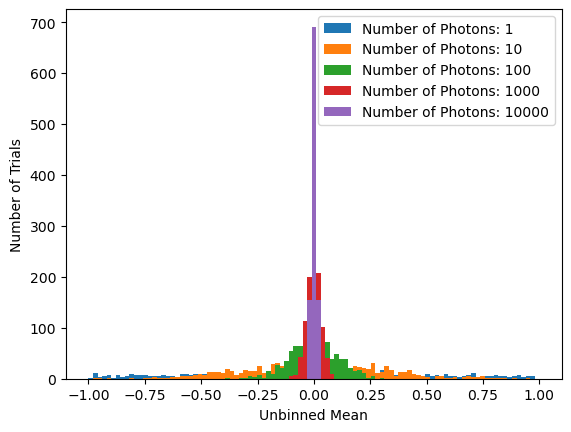

In [3]:
# Plot how the distribution of means changes with photon number
plt.figure()
for n, mean in unbinned_means:
    plt.hist(mean, bins=np.linspace(-1, 1, 100), label=f"Number of Photons: {n}")
plt.xlabel("Unbinned Mean")
plt.ylabel("Number of Trials")
plt.legend()

Text(0.5, 0, 'Number of Photons')

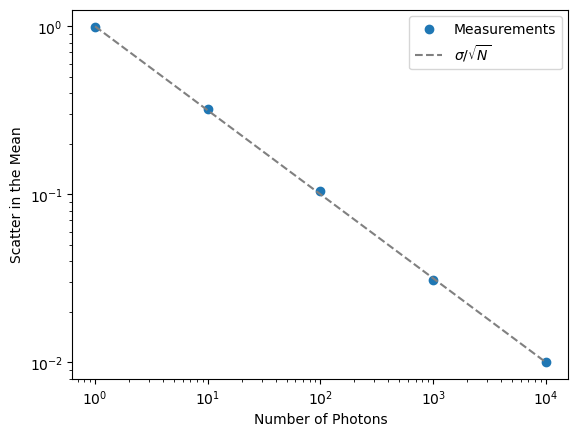

In [4]:
std = np.array([np.std(means) for nph, means in unbinned_means])
plt.scatter(nphotons, std, label="Measurements")
plt.plot(nphotons, sigma/np.sqrt(nphotons), '--', color='gray', label=r"$\sigma/\sqrt{N}$")
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.legend()
plt.ylabel("Scatter in the Mean")
plt.xlabel("Number of Photons")

The above example demonstrates that our statistical assumptions worked for continuous, unpixelized samples from a distribution. Now we want to check that the same statistical properties hold for a pixelized distribution.

<span><span style="color:blue;font-weight: bold;">Exercise:</span>  Use `np.histogram` to bin the "photons" into "pixels". Verify that our statistical assumption holds for 1D pixelated data when the mean is calculated as $$\bar{x} = \frac{ \sum_{x} x I_x } {\sum_{x} I_x},$$ where $I_x$ is the intesity (counts) in the pixel located at coordinate $x$.

In [5]:
# Draw the 1D locations "photons" from a "PSF"
mu,sigma = 0, 1
pdf = scipy.stats.norm(mu,sigma)

# Configure the bins ("pixels")
bins = np.linspace(-10,10,101)
centers = (bins[1:] + bins[:-1])/2.

# Create sources with different numbers of photons
nphotons = [1, 10, 100, 1000, 10000]
# Number of realizations of each source
ntrials = 1000

Text(0.5, 0, 'Number of Photons')

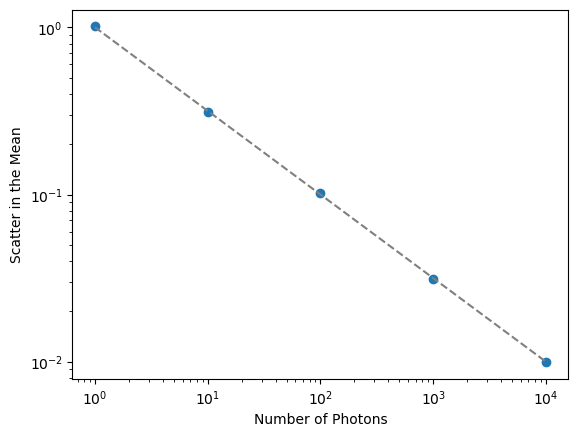

In [6]:
# Your code here...

binned_means = []
for nph in nphotons:
    x = pdf.rvs(size=(nph, ntrials))
    Ix = [np.histogram(_x, bins)[0] for _x in x.T]
    mean = [np.sum(_Ix*centers)/np.sum(_Ix) for _Ix in Ix]
    binned_means.append( [nph, mean] )

std = [np.std(means) for nph, means in binned_means]
plt.scatter(nphotons, std, label="Binned Measurements")
plt.plot(nphotons, sigma/np.sqrt(nphotons), '--', color='gray', label=r"$\sigma/\sqrt{N}$")
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.ylabel("Scatter in the Mean")
plt.xlabel("Number of Photons")

### The 2D Case

Now, let's try the 2D example. First we'll start by defining our 2D point source as a multivariate normal distribution centered at $x,y = (2,0)$ with $\sigma_x = \sigma_y = 1$. (We choose to offset the source and make our image rectangular to help double check that our array indexing is correct.)

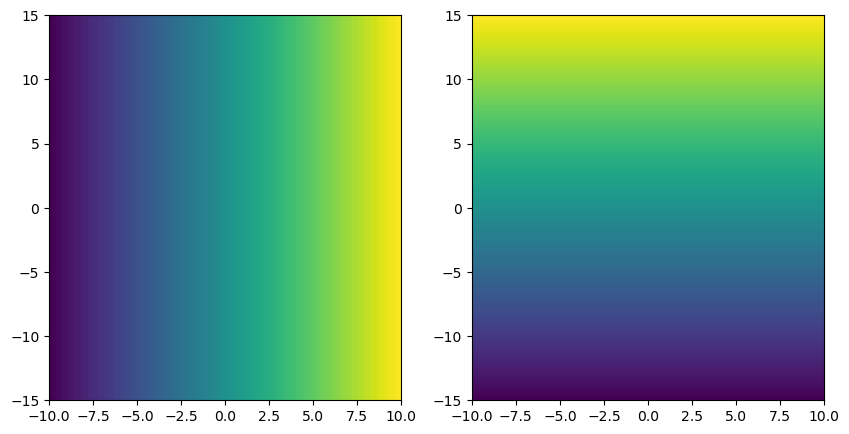

In [7]:
# Create the 2d normal distribution

# The mean of the distribution (offset to help verify indexing)
xtrue,ytrue = 2, 0
mu = np.array([xtrue,ytrue])
# The spread (now a covariance array)
sigma = 1
cov = np.array([ [sigma,0], [0,sigma] ])
# Create the multivariate normal "PSF" 
pdf = scipy.stats.multivariate_normal(mean=mu,cov=cov)

# Create the pixel edges and centers
# (Rectangular image to help verify indexing)
bins = xbins, ybins = [np.linspace(-10,10,101), np.linspace(-15,15,151)]
centers = xcenters, ycenters = [(bins[0][1:] + bins[0][:-1])/2., (bins[1][1:] + bins[1][:-1])/2.]

# x,y coordinates for the center of each pixel
# Note the convention of numpy is array[row, column]...
# The indexing='ij' is a "shortcut" that I "discovered". Does it work? I don't know...
xx,yy = np.meshgrid(xcenters, ycenters, indexing='ij')

# Sanity check for x,y coordinates...
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].pcolormesh(xx,yy,xx)
ax[1].pcolormesh(xx,yy,yy)

<span><span style="color:blue;font-weight: bold;">Exercise:</span> Generate 1000 photons from our 2D representation of a "PSF". Plot the distribution as a scatter plot. Use `np.histogram2d` to bin the photons into pixels. Call the counts in each pixel `Ixy` (the intensity).  Use `pcolormesh` to plot `Ixy` to show what the image produced from a pixelated detector would look like. (I used `plt.pcolormesh(xx,yy,Ixy)`, but any combination that has the correct x,y orientation should work.)

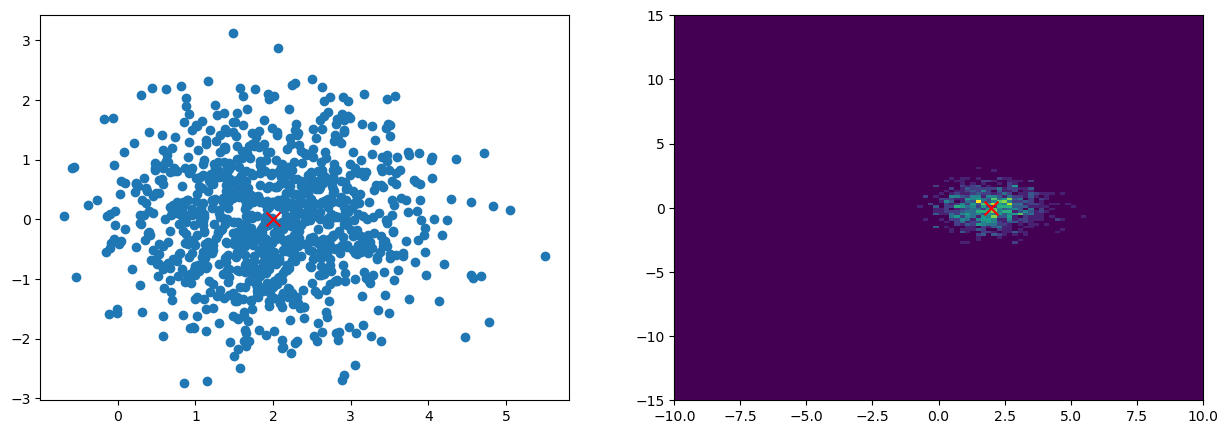

In [8]:
# Code for your answer here...

# Generate x,y coordinates of photons
xy = pdf.rvs(size=1000)
x,y = xy[:,0],xy[:,1]
Ixy = np.histogram2d(x, y, bins)[0]

# Plot the distribution of photons
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(xy[:,0], xy[:,1])
ax[0].scatter(xtrue, ytrue, marker='x', color='r', s=100)
ax[1].pcolormesh(xx, yy, Ixy)
ax[1].scatter(xtrue, ytrue, marker='x', color='r', s=100)

<span><span style="color:blue;font-weight: bold;">Exercise:</span> Calculate the 2D centroid of your pixelated distribution, $(\bar{x}, \bar{y})$, using the counts in each pixel, $I(x,y)$ from the formulae

$$\bar{x} = \frac{\sum_{xy} x I_{xy}}{\sum_{xy} I_{xy}},~~ \bar{y} = \frac{\sum_{xy} y I_{xy}}{\sum_{xy} I_{xy}}$$

Plot the centroid on top of your pixelated image. How does it look?

1.9830000000000008 -0.010199999999999295


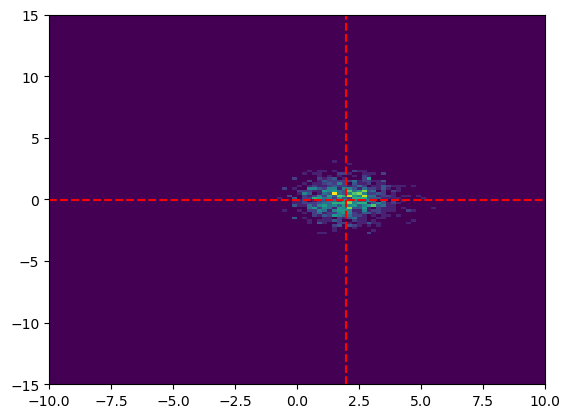

In [9]:
# Your answer below.

xbar = np.sum(xx * Ixy)/np.sum(Ixy)
ybar = np.sum(yy * Ixy)/np.sum(Ixy)
print(xbar, ybar)

plt.figure()
plt.pcolormesh(xx,yy,Ixy)
plt.axvline(xbar, color='r', ls='--')
plt.axhline(ybar, color='r', ls='--') 

### Adding noise

Now we are going to add some random noise to the counts in each pixel. This is akin to the noise that would be left after subtracting the sky background. For the purposes of this exercise, assume that the noise is Gaussian: $\mathcal{N}(\mu, \sigma)$. Note that the noise after background subtraction will fluctuate both positive and negative.

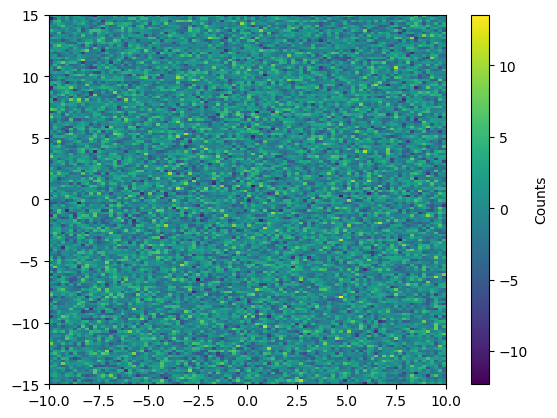

In [10]:
# Generate random Gaussian noise left over after sky subtraction.
sky_mu, sky_sigma = 0, 3
sky_noise = scipy.stats.norm(sky_mu, sky_sigma).rvs(size=Ixy.shape)

fig = plt.figure()
plt.pcolormesh(xx, yy, sky_noise)
plt.colorbar(label="Counts")

<span><span style="color:blue;font-weight: bold;">Question:</span> Add the sky noise to your pixelated counts. Plot the image of your source + noise and calculate the centroid $(\bar{x}, \bar{y})$ following the same procedure above. Do this several times for several realizations of the noise. What happens and why?

0.2647442434860224 0.41243323476179766


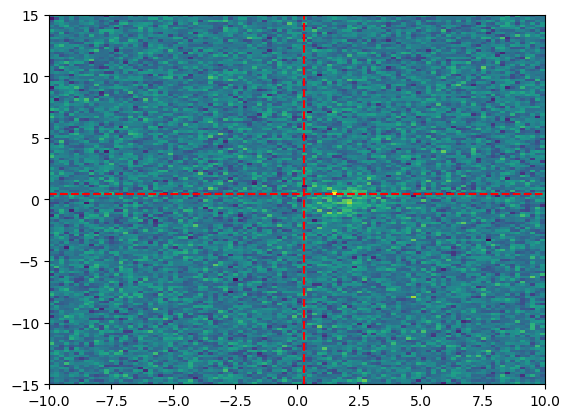

In [11]:
# Your code here...

Ixy_noise = Ixy+sky_noise

# Plot the distribution of photons
fig, ax = plt.subplots(1,1)
ax.pcolormesh(xx, yy, (Ixy + sky_noise))

xbar = np.sum(xx * (Ixy + sky_noise))/np.sum(Ixy + sky_noise)
ybar = np.sum(yy * (Ixy + sky_noise))/np.sum(Ixy + sky_noise)

plt.axvline(xbar, color='r', ls='--')
plt.axhline(ybar, color='r', ls='--')

print(xbar, ybar)

### Windowed Centroiding

As discussed in the lecture, the common way to perform centroiding in the background-dominated regime is to apply an aperture (or window) filter function. We will define two simple top-hat windows below. Applying these windows will basically amount to restricting our centroid measurement to only use the pixels around the source.

In [12]:
# Setup the top-hat window array

def square_window(x0, y0, half_width):
    """ A square top-hat window.
    
    Parameters
    ----------
    x0, y0 : center of the window
    half_width : half of the width of the square
    
    Returns
    -------
    window : the window array
    """
    window = np.zeros_like(Ixy)
    window  = (np.abs(xx - x0) < half_width)
    window &= (np.abs(yy - y0) < half_width)
    return window
    
def circular_window(x0, y0, radius):
    """ A circular top-hat window.

    Parameters
    ----------
    x0, y0 : center of the window
    radius : radius of the circle.

    Returns
    -------
    window : the window array
    """
    window = np.zeros_like(Ixy)
    window  = np.sqrt( (xx - x0)**2 + (yy - y0)**2) < radius
    return window

In order to apply the filter, we need to make an initial guess at where the window should be centered. We've just seen that our centroid estimate can be way off, so we need another estimate. We could use the true center of the object, but that is cheating. Let's try centering the window on the "peak", i.e., the pixel with the maximum number of counts (this has worked in most realizations of the noise that I have seen). In a more realistic example, you would have already run source detection, which will have given you a rough estimate for where the source is located.

<span><span style="color:blue;font-weight: bold;">Exercise:</span> Find the x,y coordinates of the pixel with the maximum value. Plot each of the two window functions centered on that pixel with a half-width/radius of `3*sigma`, where `sigma` is the effective "PSF" width that we to simulate our source (our results won't be too sensitive to our choice, and we can assume that we have measured this "PSF" from bright stars...).

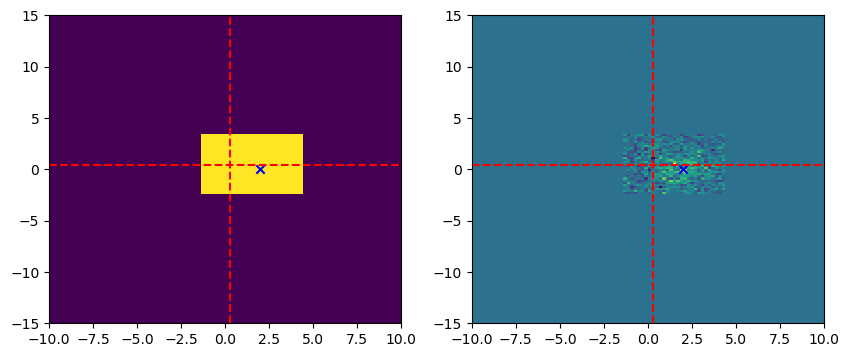

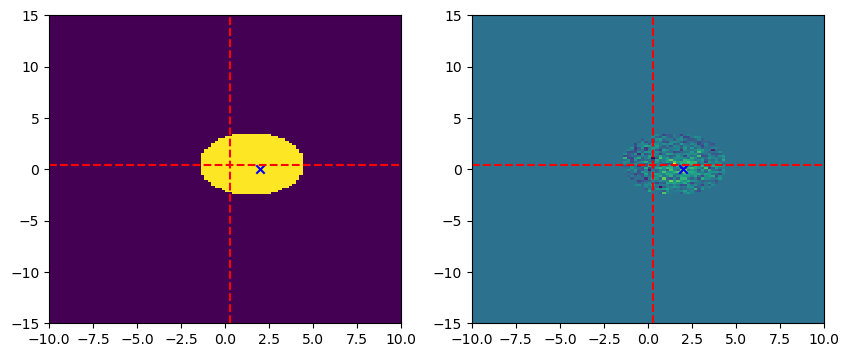

In [13]:
# Your code here...

# Find the peak
idx_x, idx_y = np.where(Ixy_noise == Ixy_noise.max())
xpeak = xx[idx_x, idx_y]
ypeak = yy[idx_x, idx_y]

# Assume the width is known (or can be approximated)
half_width = radius = sigma

# Rectangular window
window1 = square_window(xpeak,ypeak,3*half_width)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].pcolormesh(xx, yy, window1)
ax[1].pcolormesh(xx, yy, Ixy_noise * window1) 
for i in [0,1]:
    ax[i].scatter(xtrue, ytrue, marker='x', color='b')
    ax[i].axvline(xbar, color='r', ls='--')
    ax[i].axhline(ybar, color='r', ls='--')

# Circular top hat window
window2 = circular_window(xpeak,ypeak,3*radius)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].pcolormesh(xx, yy, window2)
ax[1].pcolormesh(xx, yy, Ixy_noise * window2) 
for i in [0,1]:
    ax[i].scatter(xtrue, ytrue, marker='x', color='b')
    ax[i].axvline(xbar, color='r', ls='--')
    ax[i].axhline(ybar, color='r', ls='--')

<span><span style="color:blue;font-weight: bold;">Exercise:</span> Apply the circular window and re-calculate the centroid of your noisy image

$$\bar{x} = \frac{\sum_{xy} x I_{xy} w_{xy}}{\sum_{xy} I_{xy} w_{xy}},~~ \bar{y} = \frac{\sum_{xy} y I_{xy} w_{xy}}{\sum_{xy} I_{xy} w_{xy}}.$$

Did it help? Could you imagine an iterative approach that would converge on a more correct centroid?

2.0362223552563976 -0.07504834849864951


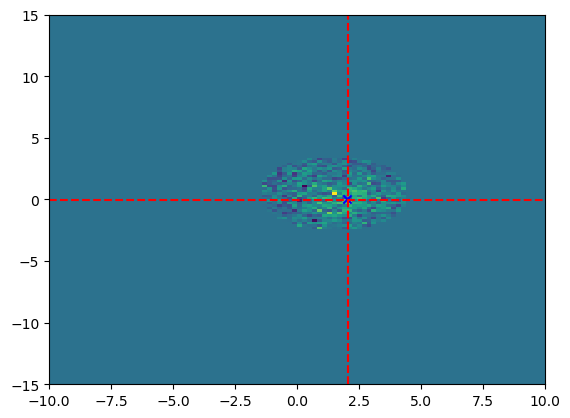

In [14]:
# Your code here...

Ixy_noise_weight = (Ixy+sky_noise)*window2

# Plot the distribution of photons
fig, ax = plt.subplots(1,1)
ax.pcolormesh(xx,yy, Ixy_noise_weight)

xbar = np.sum(xx * (Ixy_noise_weight))/np.sum(Ixy_noise_weight)
ybar = np.sum(yy * (Ixy_noise_weight))/np.sum(Ixy_noise_weight)
print(xbar, ybar)

#Plot the window
plt.axvline(xbar, color='r', ls='--')
plt.axhline(ybar, color='r', ls='--')
plt.scatter(xtrue, ytrue, marker='x', color='b')

## Excercise 2: Fast Moving Star

*(Adapted from Gary Bernstein)*

This exercise uses two CCD images and the associated catalogs from the Dark Energy Survey (DES):
* First Image: [D00387788_r_c24_r3567p02_immasked.fits.fz](https://data.darkenergysurvey.org/fnalmisc/D00387788_r_c24_r3567p02_immasked.fits.fz)
* First Catalog: [D00387788_r_c24_r3567p02_red-fullcat.fits](https://data.darkenergysurvey.org/fnalmisc/D00387788_r_c24_r3567p02_red-fullcat.fits)
* Second Image: [D00704796_r_c35_r3518p01_immasked.fits.fz](https://data.darkenergysurvey.org/fnalmisc/D00704796_r_c35_r3518p01_immasked.fits.fz)
* Second Catalog: [D00704796_r_c35_r3518p01_red-fullcat.fits](https://data.darkenergysurvey.org/fnalmisc/D00704796_r_c35_r3518p01_red-fullcat.fits)

According to Gaia, there is a fast-moving star located at roughly (29.91148,-8.212267). If you display these two images using DS9, then align them using the Frame->Match->Frame->WCS option, you will be able to move your cursor to those coordinates actually see the star move.

We are going to practice using the WCS by starting from the windowed centroids of the catalog detections of this star, applying the WCS to transform the centroids to sky coordinates, and calculating the proper motion of the star.

In [15]:
# Common astropy imports
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

In [16]:
# Open the FITS files. This returns HDU lists.

img1 = fits.open('D00387788_r_c24_r3567p02_immasked.fits.fz')
cat1 = fits.open('D00387788_r_c24_r3567p02_red-fullcat.fits')

img2 = fits.open('D00704796_r_c35_r3518p01_immasked.fits.fz')
cat2 = fits.open('D00704796_r_c35_r3518p01_red-fullcat.fits')

# Print the contents of the files
print("Image file:")
[print(hdu) for hdu in img1] 
print("Catalog file:")
[print(hdu) for hdu in cat1] 

Image file:
Catalog file:


[None, None, None]

In [17]:
# You can access the header, image, and catalog data as shown below...
header = img1[1].header
image = img1[1].data
catalog = cat1[2].data

<span><span style="color:blue;font-weight: bold;">Exercise:</span> For each of the two images, get the Modified Julien Date (`MJD-OBS`) from the header and use the header to create a World Coordinate System (WCS). How far separated in time are the two images? How far separated in angle on the sky are the centers of the two CCDs?

In [18]:
# Your code here...

mjd1 = img1[1].header['MJD-OBS']
mjd2 = img2[1].header['MJD-OBS']

wcs1 = WCS(img1[1].header)
wcs2 = WCS(img2[1].header)
print(wcs1)
print(wcs2)

x,y = img1[1].header['NAXIS1']//2, img1[1].header['NAXIS2']//2
print(x,y)
center1 = wcs1.pixel_to_world(x,y)
center2 = wcs2.pixel_to_world(x,y)

print()
print(f"Time difference: {mjd2 - mjd1:.2f} days")
print(f"Spatial Separation: {center1.separation(center2).arcmin:.2f} arcmin")

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 28.99654545257 -8.511900566422 
CRPIX : 4427.44303454 -8620.29392039 
CD1_1 CD1_2  : 1.149754008208e-07 7.285427107338e-05 
CD2_1 CD2_2  : -7.294694943635e-05 -1.710344966085e-07 
NAXIS : 2048  4096
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 29.77263077874 -8.093730477047 
CRPIX : -99.4848889592 2049.24357424 
CD1_1 CD1_2  : -1.306996100924e-07 7.332917987252e-05 
CD2_1 CD2_2  : -7.339295100021e-05 5.976438012495e-08 
NAXIS : 2048  4096
1024 2048

Time difference: 1094.91 days
Spatial Separation: 5.35 arcmin


<span><span style="color:blue;font-weight: bold;">Exercise:</span> Use the associated WCS to convert the windowed centroids of the catalogs into sky coordinates (RA, Dec). Find the catalog object associated with our target star at RA, DEC ~ (29.91148,-8.212267). What the the windowed centroid coordinates (`XWIN_IMAGE`, `YWIN_IMAGE`) for the detection? What is the major axis of the windowed image centroid error ellipse (`ERRAWIN_IMAGE`) that we will use as an estimate of the statistical uncertainty on the centroid?

In [19]:
# Your code here...

RA, DEC = (29.91148,-8.212267)
target = SkyCoord(RA, DEC, unit=u.deg)

data1 = cat1[2].data
data2 = cat2[2].data

coords1 = wcs1.pixel_to_world(data1['XWIN_IMAGE'],data1['YWIN_IMAGE'])
coords2 = wcs2.pixel_to_world(data2['XWIN_IMAGE'],data2['YWIN_IMAGE'])

sel1 = target.separation(coords1) < 1.5*u.arcsec
sel2 = target.separation(coords2) < 1.5*u.arcsec

# The coordinates matched to our star
coord1 = coords1[sel1][0]
coord2 = coords2[sel2][0]

x1, y1, sigma1 = data1['XWIN_IMAGE'][sel1][0], data1['YWIN_IMAGE'][sel1][0], data1['ERRAWIN_IMAGE'][sel1][0]
x2, y2, sigma2 = data2['XWIN_IMAGE'][sel2][0], data2['YWIN_IMAGE'][sel2][0], data2['ERRAWIN_IMAGE'][sel2][0]

print(coord1, x1, y1, sigma1)
print(coord2, x2, y2, sigma2)

<SkyCoord (ICRS): (ra, dec) in deg
    (29.9115171, -8.21232326)> 305.40353086326274 3815.981155711964 0.020776823
<SkyCoord (ICRS): (ra, dec) in deg
    (29.91177595, -8.2124225)> 1517.8108288447943 3931.9505138828695 0.020623697


<span><span style="color:blue;font-weight: bold;">Exercise:</span> Using the two sky coordinates calculated above to estimate the proper motion (in mas/yr) of the star between the two exposures. Note that proper motions are traditionally given in real angular motions, so that (RA PM) = (difference in RA) * cos(dec) / (time interval). Estimate the uncertainty on these measurements using the `ERRAWIN_IMAGE` estimates and a 10 mas turbulence uncertainty (added in quadrature).

Compare your measurement to the measurement from Gaia DR2:
```
pmra  =  326.06  +/- 0.94 mas/yr
pmdec = -124.12 +/- 0.81 mas/yr
```

Can you speculate about some inaccuracies in your estimate?

In [20]:
# Your code here...

# First get the time interval, in years:
dt = (mjd2 - mjd1) / 365.25 #(number of days in a Julian year)
print("Years between observations:",dt)

# Now get the change in dec and RA, which we convert to milliarcsec
dRA = (coord2.ra - coord1.ra).mas * np.cos(coord2.dec.rad)
dDec = (coord2.dec - coord1.dec).mas

# The uncertainty in the difference is the quadrature sum of the individual errors
pixscale = 0.2634 # arcsec/pixel
sigma_diff = np.sqrt( sigma1**2 + sigma2**2) * pixscale * 1000. # convert to mas.
# Add 2 exposures' worth of 10 mas turbulence to the sigma
sigma_diff = np.sqrt(sigma_diff**2 + 2 * 10.**2)

# Now divide by time to get the rates of motion.
print("PMRA:  {:.2f} +- {:.2f}".format(dRA/dt, sigma_diff/dt))
print("PMDec: {:.2f} +- {:.2f}".format(dDec/dt, sigma_diff/dt))

print("We have not corrected for parallax, DCR, or any of the sensor-level effects discussed in the lecture.")

Years between observations: 2.9977087906365494
PMRA:  307.67 +- 5.37
PMDec: -119.18 +- 5.37
We have not corrected for parallax, DCR, or any of the sensor-level effects discussed in the lecture.
